In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# PIL
from PIL import Image
import tensorflow as tf
# build dataset with datagenerator
from keras.preprocessing.image import ImageDataGenerator

2023-03-05 15:32:31.755903: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
train_0_path = 'resize_data/train_img/0/'
train_1_path = 'resize_data/train_img/1/'
test_0_path = 'resize_data/test_img/0/'
test_1_path = 'resize_data/test_img/1/'

In [3]:
# save the image name in a list
train_0 = os.listdir(train_0_path)
train_1 = os.listdir(train_1_path)
test_0 = os.listdir(test_0_path)
test_1 = os.listdir(test_1_path)

# check the number of images
print('Number of train_0 images: ', len(train_0))
print('Number of train_1 images: ', len(train_1))
print('Number of test_0 images: ', len(test_0))
print('Number of test_1 images: ', len(test_1))

Number of train_0 images:  35552
Number of train_1 images:  34883
Number of test_0 images:  8889
Number of test_1 images:  8723


In [4]:
# data augmentation
datagen = ImageDataGenerator(rescale=1./255,
                                rotation_range=90,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                vertical_flip=True)

# prepare an iterators for each dataset
train_it = datagen.flow_from_directory('resize_data/train_img/',
                                        class_mode='binary',
                                        batch_size=64,
                                        target_size=(224, 224))

test_it = datagen.flow_from_directory('resize_data/test_img/',
                                        class_mode='binary',
                                        batch_size=64,
                                        target_size=(224, 224))



Found 70435 images belonging to 2 classes.
Found 17612 images belonging to 2 classes.


In [5]:
# use resnet50 as the base model and fine-tune the model
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
base_model.summary()

2023-03-05 15:32:40.154995: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-05 15:32:40.155832: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-05 15:32:40.177081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 15:32:40.177223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2023-03-05 15:32:40.177245: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-05 15:32:40.179155: I tensorflow/stream_executor/platfor

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [6]:
image_batch, label_batch = next(iter(train_it))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-03-05 15:32:45.576570: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-03-05 15:32:46.259562: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


(64, 7, 7, 2048)


In [7]:
global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 2048)


In [8]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [9]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
len(model.trainable_variables)

2

In [12]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(test_it)

2023-03-05 15:32:58.482918: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-05 15:32:58.483399: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3399905000 Hz


276/276 [==============================] - 169s 606ms/step - loss: 1.0652 - accuracy: 0.4955


In [13]:
resnet50_transfer = model.fit(train_it,
                    epochs=initial_epochs,
                    validation_data=test_it)

Epoch 1/10
1101/1101 [==============================] - 818s 741ms/step - loss: 0.6735 - accuracy: 0.5258 - val_loss: 0.6534 - val_accuracy: 0.5608
Epoch 2/10
1101/1101 [==============================] - 794s 721ms/step - loss: 0.6481 - accuracy: 0.5530 - val_loss: 0.6365 - val_accuracy: 0.5512
Epoch 3/10
1101/1101 [==============================] - 793s 720ms/step - loss: 0.6391 - accuracy: 0.5662 - val_loss: 0.6287 - val_accuracy: 0.5430
Epoch 4/10
1101/1101 [==============================] - 838s 761ms/step - loss: 0.6346 - accuracy: 0.5773 - val_loss: 0.6317 - val_accuracy: 0.6487
Epoch 5/10
1101/1101 [==============================] - 821s 746ms/step - loss: 0.6289 - accuracy: 0.5869 - val_loss: 0.6200 - val_accuracy: 0.5454
Epoch 6/10
1101/1101 [==============================] - 769s 699ms/step - loss: 0.6266 - accuracy: 0.5901 - val_loss: 0.6167 - val_accuracy: 0.5954
Epoch 7/10
1101/1101 [==============================] - 768s 698ms/step - loss: 0.6243 - accuracy: 0.5918 - val_

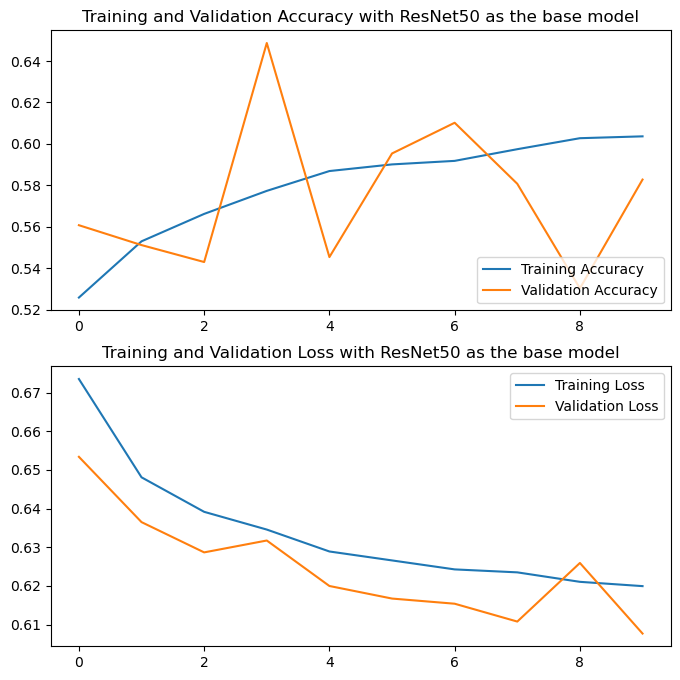

In [14]:
acc = resnet50_transfer.history['accuracy']
val_acc = resnet50_transfer.history['val_accuracy']

loss = resnet50_transfer.history['loss']
val_loss = resnet50_transfer.history['val_loss']

epochs_range = range(initial_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy with ResNet50 as the base model')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss with ResNet50 as the base model')
plt.show()

# Fine-tune

In [15]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [16]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer = tf.keras.optimizers.Adam(1e-5),
                metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 19,454,977
Non-trainable params: 4,134,784
_________________________________________________________________


In [18]:
len(model.trainable_variables)

92

In [20]:
# train the model and show the f1 score
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import f1_score

fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

# define the checkpoint
checkpoint = ModelCheckpoint('resnet50_2.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# define the early stopping
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='max')

# fit the model
resnet50_fine_tune = model.fit(train_it,
                    steps_per_epoch=len(train_it),
                    validation_data=test_it,
                    validation_steps=len(test_it),
                    initial_epoch=resnet50_transfer.epoch[-1],
                    epochs=total_epochs,
                    callbacks=[checkpoint, early])


Epoch 10/110
1101/1101 [==============================] - 756s 684ms/step - loss: 0.6826 - accuracy: 0.5618 - val_loss: 0.6273 - val_accuracy: 0.5282

Epoch 00010: val_accuracy improved from -inf to 0.52816, saving model to resnet50_2.h5
Epoch 11/110
1101/1101 [==============================] - 753s 684ms/step - loss: 0.5837 - accuracy: 0.6536 - val_loss: 0.5217 - val_accuracy: 0.7578

Epoch 00011: val_accuracy improved from 0.52816 to 0.75778, saving model to resnet50_2.h5
Epoch 12/110
1101/1101 [==============================] - 780s 709ms/step - loss: 0.5479 - accuracy: 0.6935 - val_loss: 0.5465 - val_accuracy: 0.5942

Epoch 00012: val_accuracy did not improve from 0.75778
Epoch 13/110
1101/1101 [==============================] - 966s 877ms/step - loss: 0.5382 - accuracy: 0.7031 - val_loss: 0.4997 - val_accuracy: 0.7836

Epoch 00013: val_accuracy improved from 0.75778 to 0.78356, saving model to resnet50_2.h5
Epoch 14/110
1101/1101 [==============================] - 833s 756ms/step 

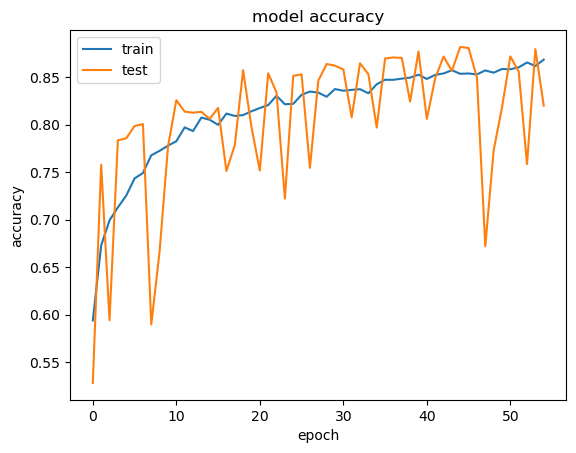

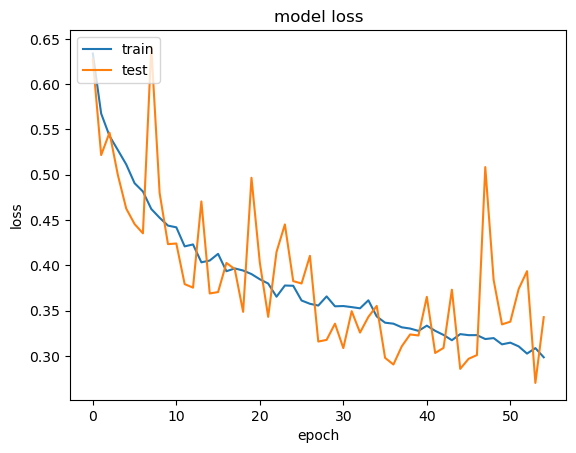

In [21]:
# plot the accuracy and loss
plt.plot(resnet50_fine_tune.history['accuracy'])
plt.plot(resnet50_fine_tune.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(resnet50_fine_tune.history['loss'])
plt.plot(resnet50_fine_tune.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
# evaluate the model with all the test data
test_loss, test_acc = model.evaluate(test_it, verbose=2)
print('Test accuracy:', test_acc)

276/276 - 157s - loss: 0.3445 - accuracy: 0.8182
Test accuracy: 0.8182489275932312


In [23]:
# save the model
model.save('resnet50_2.h5')

In [33]:
# show test_it labels
test_it.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [34]:
# use test_it to show the f1 score
y_pred = model.predict(test_it)
# y_pred ranges from -inf to inf, so we need to convert it to 0 and 1
y_pred = np.where(y_pred > 0, 1, 0)
y_pred

array([[1],
       [0],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [35]:
# count the number of 0 and 1 in y_pred
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([10451,  7161]))

In [36]:
# f1 score
print('F1 score: ', f1_score(test_it.labels, y_pred))

F1 score:  0.4456056408964996
